# Data til investeringsmodell
* Joakim Blix Prestmo
* 09.05.2018

In [1]:
import  pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.stattools import pacf,acf
from statsmodels.tsa.vector_ar.var_model import VAR
#from arch.unitroot import DFGLS

C:\Users\jop\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Henting og klargjøring av makrodata

In [2]:
#Henter en tabell med variabelnavn og forklaringer fra SSB
#df = pd.read_html('http://data.ssb.no/api/v0/dataset/59012?lang=no')[0]
#dic = {}
#for i in df.index:
#    dic[df.iloc[i, 1]] = df.iloc[i,0]

In [25]:
#Henter makrodatasettet
#makro = pd.read_excel('2017626105607714304120KNRMakroHov.xlsx', header = 3,skipfooter = 2)
#makro.index = pd.to_datetime(makro.index.str.replace('K','Q')) #setter indeksen til dato
#makro.columns = [dic[makro.columns[i]] for i in range(len(makro.columns))] #bytter variabelnavn fra forklaring til enklere navn

In [5]:
#makro = pd.read_csv('http://data.ssb.no/api/v0/dataset/59022.csv?lang=no', na_values = ['..','.'], sep = ';', encoding = 'latin1')
#makro = makro[makro['statistikkvariabel'] == 'Faste 2014-priser, sesongjustert (mill. kr)'].drop('statistikkvariabel',1)
#makro.columns = ['makrostørrelse', 'tid', 'verdi']
#makro.makrostørrelse = makro.makrostørrelse.str.split(' ').str[0]
#makro.index = pd.to_datetime(makro.tid.str.replace('K', 'Q'))
#makro = makro.pivot(columns = 'makrostørrelse', values=  'verdi')

In [26]:
#plukker ut de variablene vi vil bruke videre i analysen
#vars_of_interest = ['bnpb.nr23_9', 'bnpb.nr23_9fn', 'bif.nr83_6', 'bif.nr83naer', 'bif.nr8368', 'bif.nr83oljroer', 'koo.nroff', 'eks.nrtot', 'eks.puboljegs', 'imp.nrtot', 'koh.nrpriv']
#makro = makro[vars_of_interest]

In [ ]:
#bolig = pd.read_excel('boligprisdata.xslx', sep = ',', na_values = "")
#bolig.index = bolig.dato
#invest.drop = ('dato', 1, inplace= True)

# Henting og klargjøring av investeringsdata

In [3]:
#Henter investdata og setter index til dato
invest = pd.read_excel('investdata_mars2017.xlsx', sep = ',', na_values='#N/A')
invest.index = invest.dato
invest.drop('dato', 1, inplace = True)
dates = pd.date_range('19800101', periods=164, freq='Q')

#dates = pd.date_range('20130101', periods=4, freq='MS')
invest.index=dates


In [4]:
invest.index = pd.DatetimeIndex(invest.index)


In [5]:
invest.head()


,K1015,K4015,K5015,K1025,K4025,K5025,K1030,K4030,K5030,K1045,...,BG100,BG100NOK,BG100VALUTA,RENREALLONG,PBKGAMMA,JKS66,SJKS66,DKV1,DKV2,DKV3
1980-03-31,35491.07813,2079.83288,13445.65737,51784.28032,2134.03618,24567.66604,47695.59983,101.32742,37507.16551,52752.24245,...,NaN,NaN,NaN,0.005,0.025,13104.0,13638.0,1,0,0
1980-06-30,35791.65687,2106.68028,13507.59189,52003.79669,2127.07663,24747.79575,47952.97361,113.42272,37939.34311,52557.44744,...,NaN,NaN,NaN,0.005,0.025,13264.0,13829.0,0,1,0
1980-09-30,36178.04533,2115.08133,13628.85012,52052.57500,2147.99189,24809.32287,48133.27244,119.56339,38682.35513,52361.60836,...,NaN,NaN,NaN,0.005,0.025,13863.0,14334.0,0,0,1
1980-12-31,36688.18408,2138.11503,13874.04688,52344.78833,2189.07632,25132.52759,48951.84570,131.49222,39381.42969,52285.26392,...,NaN,NaN,NaN,0.005,0.025,14436.0,14431.0,0,0,0
1981-03-31,36633.64319,2116.87639,13895.41043,52141.06577,2199.78118,25120.87219,49527.44087,110.54289,39648.46336,52984.26896,...,NaN,NaN,NaN,0.005,0.025,12077.0,12520.0,1,0,0


## Generer aggegerte data for industrien

In [6]:
ols_data = invest['1984':'2016'].copy()
ols_data['RRT']=(1+ols_data.RENPF300BO*(1-ols_data.TRTMNW))/(ols_data.KPI/ols_data.KPI.shift(4))-1
ols_data['BPAK']=ols_data.PJ10**0.33*ols_data.PJ40**0.04*ols_data.PJ50**0.63;
ols_data['UC'] = (400*ols_data.BPAK*(ols_data.REN100+ols_data.DEPRATE50-((ols_data.BPAK-ols_data.BPAK.shift(4))
                                                                          /ols_data.BPAK.shift(4))/4*
                                      (1-ols_data.TRTB*ols_data.DEPRATE50)/(1-ols_data.TRTB)))
# USERCOST_HL = 400*(BPAK*(REN100+DEPRATE50-((BPAK-BPAK_4)/BPAK_4)/4)*(1-TRTB*DEPRATE50)/(1-TRTB));

ols_data['S']=ols_data.REN100-ols_data.RNOK
ols_data['JKS15'] = ols_data.JK1015+ols_data.JK4015+ols_data.JK5015+ols_data.JK6015
ols_data['JKS25'] = ols_data.JK1025+ols_data.JK4025+ols_data.JK5025+ols_data.JK6025
ols_data['JKS30'] = ols_data.JK1030+ols_data.JK4030+ols_data.JK5030+ols_data.JK6030
ols_data['JKS45'] = ols_data.JK1045+ols_data.JK4045+ols_data.JK5045+ols_data.JK6045
ols_data['JK3']=ols_data.JKS15+ols_data.JKS25+ols_data.JKS30+ols_data.JKS45
# ols_data['log_JK3']=np.log(ols_data['JK3'])
ols_data['X3']=ols_data.X15+ols_data.X25+ols_data.X30+ols_data.X45
# ols_data['log_X3']=np.log(ols_data['X3'])
ols_data['YE3']=ols_data.YE15+ols_data.YE25+ols_data.YE30+ols_data.YE45
ols_data['Y3']=ols_data.Y15+ols_data.Y25+ols_data.Y30+ols_data.Y45
ols_data['YE_Y3']=ols_data.YE3/ols_data.Y3
# ols_data['log_YE_Y3']=np.log(ols_data['YE_Y3'])
# ols_data['Dlog_X3']=ols_data['log_X3'].diff(1)
# ols_data['Dlog_JK3']=ols_data['log_JK3'].diff()
# ols_data['Dlog_YE_Y3']=ols_data['log_YE_Y3'].diff()
ols_data['K3']=ols_data.K1015+ols_data.K4015+ols_data.K5015+ols_data.K1025+ols_data.K4025+ols_data.K5025+ols_data.K1030+ols_data.K4030+ols_data.K5030+ols_data.K1045+ols_data.K4045+ols_data.K5045+ols_data.K6015+ols_data.K6025+ols_data.K6030+ols_data.K6045

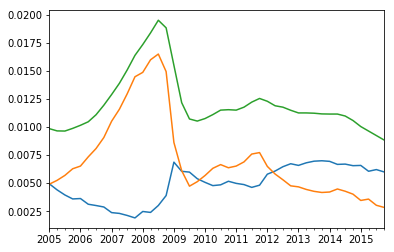

0.004561894531250001

In [7]:
ols_data['S']['2005':'2015'].plot()
ols_data['RNOK']['2005':'2015'].plot()
ols_data['REN100']['2005':'2015'].plot()
#ols_data['KURVECU']['1990':'1999'].plot()
#ols_data['OLJEPRIS']['1990':'1999'].plot()

meanS = ols_data['S'].mean()
plt.show()
meanS



In [8]:
ols_data.describe()


,K1015,K4015,K5015,K1025,K4025,K5025,K1030,K4030,K5030,K1045,...,JKS15,JKS25,JKS30,JKS45,JK3,X3,YE3,Y3,YE_Y3,K3
count,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,...,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000
mean,45640.425994,1562.891792,19318.989702,69241.373742,1670.978478,29756.599991,60586.378891,352.328304,38909.956379,46076.393392,...,1496.534137,2233.381913,1944.417106,2336.024689,8010.357845,156297.977502,5600.212781,34106.544878,0.158954,372568.327116
std,2027.371942,248.403979,4367.405560,6561.264251,518.551609,3146.472422,5309.990609,191.993950,2905.895794,8516.540429,...,459.454621,828.739623,687.880115,516.645414,1870.922682,34723.942938,3125.318293,13329.325776,0.056115,17388.698612
min,40587.469410,1133.097350,14146.120240,53830.590950,1005.610570,25151.477410,50734.426180,107.864700,32508.873420,31864.739830,...,406.413330,1013.911710,805.323920,1452.650210,4437.904680,99584.222550,158.911730,13762.298180,0.009054,321272.627580
25%,44606.313122,1377.611083,15207.627815,66239.764357,1195.795945,26956.610175,55808.297707,142.256073,36866.740435,38336.847950,...,1180.315005,1687.386718,1449.514997,1931.293455,6749.245810,122263.461842,3337.174968,21381.052595,0.126100,366137.651440
50%,45703.335045,1546.443065,18160.904695,70160.989135,1636.582075,29843.031280,61775.905430,422.704655,39266.672755,47430.995880,...,1468.057980,2028.653975,1838.600990,2319.965480,7766.136420,158264.620490,5355.386300,32907.830010,0.164514,373563.460475
75%,46835.614913,1771.074045,22630.053233,74538.328900,2049.874282,31414.091100,65393.309175,466.359600,40875.750160,54696.608678,...,1705.396210,2583.941060,2370.985748,2631.395925,9083.429590,188927.602250,7609.815812,46896.531440,0.202663,383936.520365
max,48829.970700,2059.627360,26863.911320,78659.264770,2969.350040,37334.705080,67172.013670,778.189780,43744.118650,56610.645590,...,3545.905870,6488.958830,4000.000990,4027.262370,15003.511640,219772.809350,13669.810630,60825.294820,0.267138,402077.821450


# Find Order of Integration

In [9]:

#de kontinuerlige variablene
continuous_vars = ["K1015","K4015","K5015","K1025","K4025","K5025",
                   "K1030","K4030","K5030","K1045","K4045","K5045",
                   "JK1015","JK4015","JK5015","JK1025","JK4025","JK5025",
                   "JK1030","JK4030","JK5030","JK6015","JK6025","JK6030",
                   "JK6045","K6015","K6025","K6030","K6045","JK1045","JK4045",
                   "JK5045","PJ10","PJ40","PJ50","AVSKR50","RNOK","RISIKOPR",
                   "TRTB","KPI","X15","X25","X30","X45",
                   "YE15","YE25","YE30","YE45","Y15","Y25","Y30","Y45"]


continuous_vars_agg =['JKS15', 'JKS25','JKS30', 'JKS45', 'JK3', 'X3', 'YE_Y3', 'K3',
                      "BORSI","UKPINY","MII","PX46","URKORR","REN100" ]
continuous_vars_nonlog =['S','RRT', 'UC']

#continuous_vars

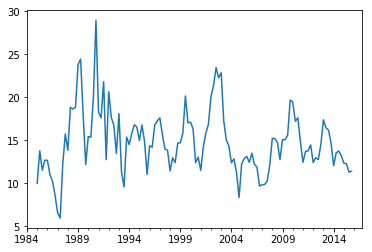

In [10]:
# invest['JK1025'].plot()
# invest['JK1015'].plot()
# ols_data['BPAK'].plot()
ols_data['UC'].plot()
plt.show()

In [11]:
test_data = np.log(ols_data['01-01-1985':'01-10-2014'])
order = {}
for var in continuous_vars_agg:
    for i in range(3):
        p = 0
        if i == 0:
            p = adfuller(test_data[var].dropna())[1]
        else:
            p = adfuller(test_data[var].diff(i).dropna())[1]
        if p < .05:
            order[var] = i
            break
order



C:\Users\jop\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
C:\Users\jop\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


{'BORSI': 1,
 'JK3': 1,
 'JKS15': 1,
 'JKS25': 0,
 'JKS30': 1,
 'JKS45': 1,
 'K3': 1,
 'MII': 1,
 'PX46': 0,
 'REN100': 1,
 'URKORR': 1,
 'X3': 1,
 'YE_Y3': 1}

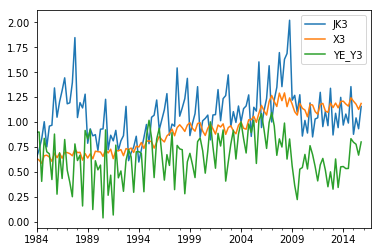

In [12]:
(ols_data[['JK3', 'X3', 'YE_Y3']]/(ols_data[['JK3', 'X3', 'YE_Y3']].iloc[80,:])).plot()
plt.show()

# Legge til transformerte variable

In [208]:
#lage nye dummy-variable
# data['1992_step'] = (data.index >= '1992').astype(np.int64)
# data['DKV1_step'] = data['DKV1']*data['1992_step']
# data['DKV2_step'] = data['DKV2']*data['1992_step']
# data['DKV3_step'] = data['DKV3']*data['1992_step']

In [13]:
for col in continuous_vars:
    ols_data['log_' + col] = np.log(ols_data[col])
for col in continuous_vars_agg:
    ols_data['log_' + col] = np.log(ols_data[col])
    

C:\Users\jop\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


In [14]:
for col in continuous_vars:
    for i in range(1,4):
        ols_data['log_' + col + '_' + str(i)] = ols_data['log_' + col].shift(i)
for col in continuous_vars_agg:
    for i in range(1,4):
        ols_data['log_' + col + '_' + str(i)] = ols_data['log_' + col].shift(i)        

for col in continuous_vars_nonlog:
    for i in range(1,4):
        ols_data[col+'_'+str(i)] = ols_data[col].shift(i)

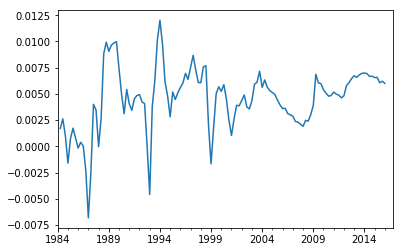

In [15]:
ols_data['S_1'].plot()
plt.show()

In [16]:
for col in continuous_vars_agg:
    for i in range(0,5):
        if i == 0:
            ols_data['Dlog_' + col] = ols_data['log_' + col].diff()
        else:
            ols_data['Dlog_' + col + '_' + str(i)] = ols_data['log_' + col].shift(i).diff()

for col in continuous_vars_nonlog:
    for i in range(0,5):
        if i==0:
            ols_data['D'+col] = ols_data[col].diff()
        else: 
            ols_data['D'+col+'_'+str(i)]=ols_data[col].shift(i).diff()

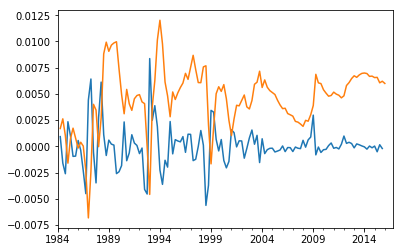

In [17]:
#investdata = ols_data[:'2015-10-01']
#investdata
ols_data['DS'].plot()
ols_data['S_1'].plot()
plt.show()

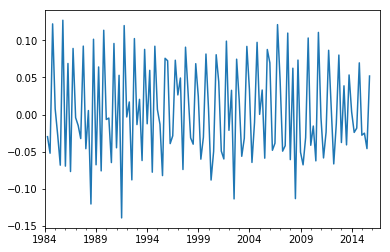

In [18]:
ols_data['Dlog_X3'].plot()
plt.show()


# Lagre

In [20]:
ols_data.to_csv('samlet_datasett_090518.csv')
#ols_data.to_csv('C:\Users\jop\Dropbox\PhD\Agginvest\R\samlet_datasett_10092017')
ols_data_est = ols_data[:-8]

# Threshold model
* Starter med å lage dummyvariabler

In [217]:
medianDx3 = ols_data_est['Dlog_X3_4'].median()
highDx3 = ols_data_est['Dlog_X3_4'] >= medianDx3
highmedianDx3 = medianDx3*(-10)
higherDx3 = ols_data_est['Dlog_X3_4'] >= highmedianDx3
HDUMX3 = higherDx3

In [218]:
print(medianDx3, highmedianDx3)



-0.004679325155555247 0.04679325155555247


In [219]:
# timedummies
# generate a datetime index to use date information
ols_data.index = pd.DatetimeIndex(ols_data.index)
#quarter dummies:

#if ols_data.all(ols_data.index.quarter == 1):
#    ols_data['DKV1'] =1 


#df =pd.get_dummies(ols_data.index.quarter, prefix='DKV')    
#ols_data['DKV1'] 
#ols_data['DKV1'] =df.DKV_1
#ols_data['DKV1']


In [226]:
#df['DKV_1']=(df['DKV_1']).astype(bool)
#ols_data['DKV_1']=ols_data['DKV_1'].astype(bool)
#ols_data['DKV_1']=df['DKV_1']
#df['DKV_1']
#ols_data['DKV_1']
#df['viz'] = (df['viz'] !='n').astype(int)
#df.head()
ols_data.index


DatetimeIndex(['1984-03-31', '1984-06-30', '1984-09-30', '1984-12-31',
               '1985-03-31', '1985-06-30', '1985-09-30', '1985-12-31',
               '1986-03-31', '1986-06-30',
               ...
               '2014-09-30', '2014-12-31', '2015-03-31', '2015-06-30',
               '2015-09-30', '2015-12-31', '2016-03-31', '2016-06-30',
               '2016-09-30', '2016-12-31'],
              dtype='datetime64[ns]', length=132, freq='Q-DEC')

In [239]:
#highDx3.plot()
#higherDx3.plot()
#ols_data['DKV1'].plot()

ols_data_est['DUM931']=0

ols_data_est.loc[:'1993-09-30'] 
#ols_data_est.loc['1993-09-30':'DUM931']=1


#plt.show()

KeyError: '1993-09-30'

In [223]:
formel = 'Dlog_JK3 ~ 1 + Dlog_JK3_3 +Dlog_X3_3 + Dlog_YE_Y3_1+ log_JK3_1 + log_X3_1 + log_YE_Y3_3 + S_1 + DKV1 + DKV2 + DKV3'

ECmodel = smf.ols(formel, data = ols_data_est)
result = ECmodel.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               Dlog_JK3   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     74.81
Date:                Mon, 11 Dec 2017   Prob (F-statistic):           3.99e-44
Time:                        10:17:20   Log-Likelihood:                 121.97
No. Observations:                 120   AIC:                            -221.9
Df Residuals:                     109   BIC:                            -191.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.5801      0.586      2.699   

In [ ]:
TARmodel = smf.ols('Dlog_JK3 ~ 1 + Dlog_JK3_1 + log_JK3_1 + (HDUMX3)*log_X3_1 + HDUMX3*log_X3_1 + log_YE_Y3_1', 
                   data = ols_data)
result = TARmodel.fit()
print(result.summary())

In [76]:
ols_data.tail()

,K1015,K4015,K5015,K1025,K4025,K5025,K1030,K4030,K5030,K1045,...,DRRT,DRRT_1,DRRT_2,DRRT_3,DRRT_4,DUC,DUC_1,DUC_2,DUC_3,DUC_4
dato,,,,,,,,,,,,,,,,,,,,,
2013-10-01,45122.00000,1373.00000,26437.00000,62086.00000,2019.00000,31986.00000,58621.00000,445.00000,35192.00000,32862.00000,...,0.006631,-0.009711,-0.007115,-0.000144,-0.008072,-1.524003,-0.289546,-0.906161,2.881052,1.738080
2014-01-01,44950.85189,1334.55747,26329.20981,61442.51776,1981.40327,31545.74059,58284.73866,429.08601,34572.04954,32741.37670,...,0.001861,0.006631,-0.009711,-0.007115,-0.000144,-2.615974,-1.524003,-0.289546,-0.906161,2.881052
2014-04-01,45028.89566,1287.41744,26459.50688,60851.95782,1947.37686,31239.03081,57964.18876,415.42149,34114.62172,32677.25208,...,0.002679,0.001861,0.006631,-0.009711,-0.007115,1.500469,-2.615974,-1.524003,-0.289546,-0.906161
2014-07-01,44983.82277,1257.17836,26462.44934,60183.09098,1889.13452,30789.58134,57600.37950,405.91495,33579.08036,32682.59793,...,-0.003022,0.002679,0.001861,0.006631,-0.009711,0.210360,1.500469,-2.615974,-1.524003,-0.289546
2014-10-01,45008.63335,1228.63344,26863.91132,59655.72159,1861.50703,31505.95344,57451.07448,403.80079,33492.49197,32638.62799,...,0.001063,-0.003022,0.002679,0.001861,0.006631,-0.551075,0.210360,1.500469,-2.615974,-1.524003


# Estimere modell

# Joakims modell

                            OLS Regression Results                            
Dep. Variable:              Dlog_PBOL   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     15.04
Date:                Wed, 28 Jun 2017   Prob (F-statistic):           1.60e-16
Time:                        15:03:03   Log-Likelihood:                 452.49
No. Observations:                 177   AIC:                            -887.0
Df Residuals:                     168   BIC:                            -858.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0706      0.105     -0.672   

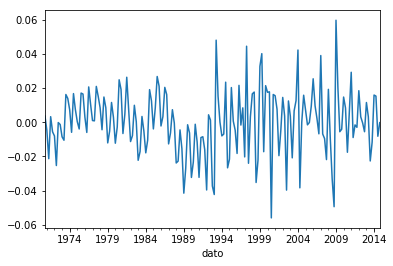

In [22]:
model = smf.ols('Dlog_PBOL~1 + Dlog_PBOL_1 + Dlog_RD300 + log_RD300_1 + Dlog_RD300_2 + log_PBOL_1 + DKV1 + DKV2 + DKV3', data = data)
result = model.fit()
print(result.summary())
result.resid.plot()
plt.show()

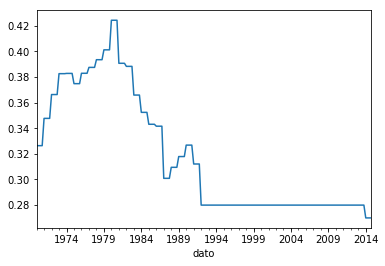

In [23]:
data.TRTMNW.plot()
plt.show()

# MODAG-inspirert

                            OLS Regression Results                            
Dep. Variable:           log_PBOL_KPI   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     352.5
Date:                Wed, 28 Jun 2017   Prob (F-statistic):           7.18e-57
Time:                        15:03:03   Log-Likelihood:                 83.712
No. Observations:                 116   AIC:                            -159.4
Df Residuals:                     112   BIC:                            -148.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -22.5820      3.014     -7.492      0.0

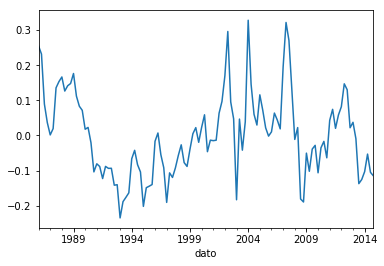

In [24]:
ols_data = data['1985':].copy()
ols_data['log_RD_KPI'] = np.log((ols_data.RD300-ols_data.RAM300)/ols_data.KPI)
ols_data['RRT']=(1+ols_data.RENPF300BO*(1-ols_data.TRTMNW))/(ols_data.KPI/ols_data.KPI.shift(4))-1
ols_data['log_PBOL_KPI'] = ols_data.log_PBOL - ols_data.log_KPI
ols_data['const'] = 1

model = sm.OLS(endog = ols_data.log_PBOL_KPI, exog = ols_data[['const','log_RD_KPI','RRT','log_K83']], missing = 'drop')
res = model.fit()
print(res.summary())
res.resid.plot()
plt.show()

In [25]:
adfuller(res.resid.dropna())

(-4.1277888178324789,
 0.00087100886819476645,
 0,
 115,
 {'1%': -3.4885349695076844,
  '10%': -2.5803597920604915,
  '5%': -2.8870195216569412},
 -232.42983334240444)

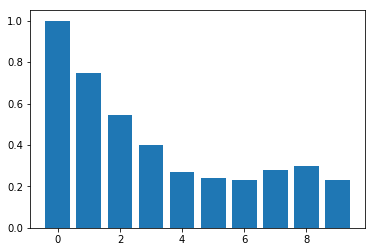

In [26]:
plt.bar(np.arange(10),acf(res.resid)[:10])
plt.show()

In [27]:
acf(res.resid, qstat = True)

(array([ 1.        ,  0.74908959,  0.54463099,  0.40037079,  0.26754165,
         0.24077183,  0.22971796,  0.28019267,  0.29824653,  0.23050404,
         0.16726216,  0.1386624 ,  0.1393537 ,  0.10335793,  0.04450283,
         0.03267057,  0.01645864, -0.02795188, -0.07967469, -0.01818343,
         0.05632712,  0.00342411,  0.00372315, -0.04486425, -0.1139479 ,
        -0.2346548 , -0.34108819, -0.34591011, -0.32893285, -0.28151793,
        -0.24323408, -0.17723222, -0.13461644, -0.20627402, -0.28253918,
        -0.31840072, -0.33344632, -0.33101604, -0.3146158 , -0.23030922,
        -0.16799585]),
 array([  66.78972905,  102.40529474,  121.8224818 ,  130.57040101,
         137.71912218,  144.28567176,  154.14453934,  165.41825391,
         172.21519173,  175.82787195,  178.33437423,  180.89027327,
         182.30995302,  182.57572861,  182.72038316,  182.75746213,
         182.86548774,  183.75214277,  183.79880008,  184.2511806 ,
         184.25286992,  184.25488843,  184.55113813, 

# Test av VAR-modell

In [28]:
VAR_model = VAR(ols_data[['log_PBOL_KPI','log_RD_KPI','RRT','log_K83']].dropna())

In [29]:
VAR_res = VAR_model.fit()

In [30]:
VAR_res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 28, Jun, 2017
Time:                     15:03:03
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -38.3216
Nobs:                     115.000    HQIC:                  -38.6053
Log likelihood:           1598.23    FPE:                1.41220e-17
AIC:                     -38.7990    Det(Omega_mle):     1.19114e-17
--------------------------------------------------------------------
Results for equation log_PBOL_KPI
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   1.642475         0.805408            2.039           0.044
L1.log_PBOL_KPI         0.955154         0.020399           46.823           0.000
L1.log_RD_KPI           0.358637         0.06

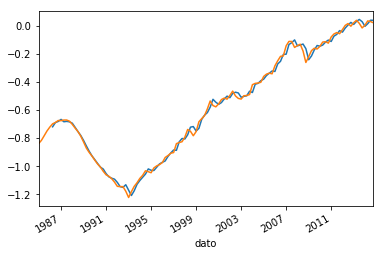

In [31]:
plt.plot(ols_data.index[5:],VAR_model.predict(VAR_res.params)[:,0])
ols_data['log_PBOL_KPI'].plot()
plt.show()

In [32]:
VAR_model.predict(VAR_res.params, 100, 110)

array([[ -1.09143617e-01,   1.25154785e+01,  -1.27599624e-02,
          1.48193716e+01],
       [ -7.11560643e-02,   1.25224432e+01,  -7.96663314e-03,
          1.48257737e+01],
       [ -5.87247538e-02,   1.25139693e+01,  -7.99257801e-03,
          1.48323244e+01],
       [ -3.16611239e-02,   1.25574702e+01,  -8.49616417e-03,
          1.48387854e+01],
       [ -4.26606264e-02,   1.25639373e+01,  -3.79711039e-03,
          1.48453596e+01],
       [ -1.34813654e-02,   1.25753740e+01,  -3.33583489e-03,
          1.48524088e+01],
       [  8.16379479e-03,   1.25734855e+01,  -1.01361374e-03,
          1.48596018e+01],
       [  2.67214552e-02,   1.25960892e+01,  -8.46178992e-04,
          1.48671612e+01],
       [  1.25520133e-02,   1.26053766e+01,  -5.65419353e-03,
          1.48748196e+01],
       [  3.41923972e-02,   1.26109626e+01,  -5.78990536e-03,
          1.48829230e+01],
       [  4.78519072e-02,   1.26090163e+01,  -1.05017905e-02,
          1.48904993e+01]])

In [33]:
VAR_res.params.T

,const,L1.log_PBOL_KPI,L1.log_RD_KPI,L1.RRT,L1.log_K83
log_PBOL_KPI,1.642475,0.955154,0.358637,-0.210288,-0.413493
log_RD_KPI,-1.487387,0.030911,0.741240,0.405946,0.320094
RRT,-0.723006,-0.018641,-0.007334,0.678768,0.054696
log_K83,0.317023,0.010862,0.006056,0.002241,0.974012


In [34]:
ols_data[['const','log_PBOL_KPI','log_RD_KPI','RRT','log_K83']].tail(1).T

dato,2014-10-01 00:00:00
const,1.000000
log_PBOL_KPI,0.024022
log_RD_KPI,12.649067
RRT,-0.012898
log_K83,14.927241


In [35]:
np.dot(VAR_res.params.T, ols_data[['const','log_PBOL_KPI','log_RD_KPI','RRT','log_K83']].tail(1).T)

array([[  3.22374772e-02],
       [  1.26622334e+01],
       [ -8.52417701e-03],
       [  1.49331694e+01]])

In [36]:
pred = np.zeros((100,4))

In [37]:
pred[0] = np.dot(VAR_res.params.T, ols_data[['const','log_PBOL_KPI','log_RD_KPI','RRT','log_K83']].tail(1).T).reshape(4)

In [38]:
pred[0]

array([  3.22374772e-02,   1.26622334e+01,  -8.52417701e-03,
         1.49331694e+01])

In [39]:
for i in range(1,100):
    pred[i] = np.dot(VAR_res.params.T, np.hstack([np.ones(1), pred[i-1]]))

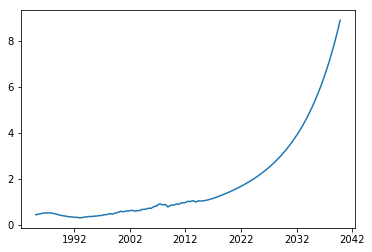

In [40]:
plt.plot(pd.date_range('1985-01-01', periods = 220, freq = '3M'),np.exp(np.hstack([ols_data.log_PBOL_KPI.values,pred[:,0]])))
plt.show()

In [41]:
data.columns[:30]

Index(['PBOL', 'PC', 'KPI', 'PJ10', 'RAM300', 'K83', 'BF300', 'BG300',
       'NFI300', 'HUSBOL', 'HUSFORMUE', 'RD300', 'KBOL', 'JKBOL', 'SPARERAT',
       'XSBOLU', 'RENPF300BO', 'TRTMNW', 'NB', 'DKV1', 'DKV2', 'DKV3',
       'bnpb.nr23_9', 'bnpb.nr23_9fn', 'bif.nr83_6', 'bif.nr83naer',
       'bif.nr8368', 'bif.nr83oljroer', 'koo.nroff', 'eks.nrtot'],
      dtype='object')

In [42]:
begrep = {}
begrep['PBOL'] = 'Boligprisindeks'
begrep['PC'] = 'Privat konsum'
begrep['KPI'] = 'KPI'
begrep['PJ10'] = 'Pris på investering i boligmasse'
begrep['RAM300'] = 'Privat aksjeutbytte'
begrep['K83'] = 'Boligkapitalbeholdning'
begrep['BF300']  = 'Private bruttofordringer'
begrep['BG300'] = 'Privat gjeld'
begrep['NFI300'] = 'Privat nettofinansinvestering'
begrep['HUSBOL'] = 'Husholdningsektorens boligkapital'
begrep['HUSFORMUE'] = 'Husholdningens formue'
begrep['RD300'] = 'Privat netto disponibel inntekt'
begrep['KBOL'] = 'Boligkapital'
begrep['JKBOL'] = 'Investering boligkapital'
begrep['SPARERAT'] = 'Husholdningens sparerate'
begrep['XSBOLU'] = 'Igangsetting av bolig i kkvm'
begrep['RENPF300BO'] = 'Rente på lån med pant i bolig'
begrep['TRTMNW'] = 'Gjennomsnitt marginal skatterate'
begrep['NB'] = 'Antall personer i kilo'

# Anundsens modell

In [43]:
mod_data = data['1985':].copy()
mod_data['const'] = 1
mod_data['log_PBOL_KPI'] = mod_data['log_PBOL'] - mod_data['log_KPI']
mod_data['log_BG_KPI'] = mod_data['log_BG300'] - mod_data['log_KPI']
mod_data['log_RD_KPI'] = np.log((mod_data['RD300'] - mod_data['RAM300'])/mod_data['KPI'])
mod_data['RRT'] = (1+mod_data.RENPF300BO*(1-mod_data.TRTMNW))/(mod_data.KPI/data.KPI.shift(4))-1
mod_data['t'] = np.arange(len(mod_data.index))

In [44]:
mod = sm.OLS(endog = mod_data['log_PBOL_KPI'], exog = mod_data[['const','log_BG_KPI','log_RD_KPI','log_K83']])
res2 = mod.fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_PBOL_KPI   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     439.8
Date:                Wed, 28 Jun 2017   Prob (F-statistic):           3.56e-63
Time:                        15:03:04   Log-Likelihood:                 98.071
No. Observations:                 120   AIC:                            -188.1
Df Residuals:                     116   BIC:                            -177.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.6109      3.670      5.888      0.000      14.342      28.880
log_BG_KPI     1.3148      0.100     13.213      0.000       1.118       1.512
log_RD_KPI     2.6245      0.270      9.705      0.000       2.089       3.160
log_K83       -4.9793      0.522     -9.531      0.000      -6.014      -3.945
==============================================================================
Omnibus:                        4.008   Durbin-Watson:                   0.486
Prob(Omnibus):                  0.135   Jarque-Bera (JB):                3.530
Skew:                          -0.409   Prob(JB):                        0.171
Kurtosis:                       3.189   Cond. No.                     8.85e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.85e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

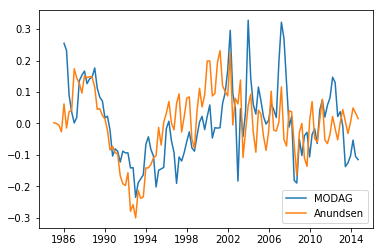

In [45]:
plt.plot(ols_data.index[4:], res.resid, label = 'MODAG')
plt.plot(mod_data.index, res2.resid, label = 'Anundsen')
plt.legend()
plt.show()

In [46]:
adfuller(res2.resid)

(-3.5120982270938095,
 0.0076817681225110259,
 8,
 111,
 {'1%': -3.4906830827540469,
  '10%': -2.5808574442009578,
  '5%': -2.8879516565798817},
 -355.24254551980505)

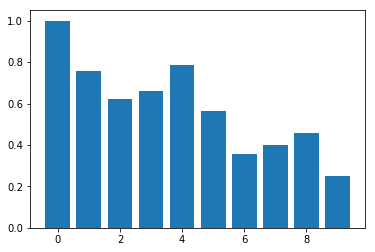

In [47]:
plt.bar(np.arange(10), acf(res2.resid)[:10])
plt.show()

# ECM

In [48]:

mod_data['Dlog_BG_KPI_1'] = mod_data['log_BG_KPI'].diff().shift()
mod_data['Dlog_K83_1'] = mod_data['log_K83'].diff().shift()
mod_data['Dlog_RD_KPI_1'] = mod_data['log_RD_KPI'].diff().shift()
mod_data['DRRT_1'] = mod_data['RRT'].diff().shift()
mod_data['Anundsen error_1'] = res2.resid.shift()
mod_data['Dlog_PBOL_KPI'] = mod_data['log_PBOL_KPI'].diff()
mod_data['Dlog_PBOL_KPI_1'] = mod_data['Dlog_PBOL_KPI'].shift()

lim_data = mod_data.copy()
ecm_mod = sm.OLS(endog = lim_data['Dlog_PBOL_KPI'][2:], exog = lim_data[['Dlog_PBOL_KPI_1','Dlog_BG_KPI_1','Dlog_K83_1', 'Dlog_RD_KPI_1', 'DRRT_1', 'Anundsen error_1','const','DKV1_step','DKV2_step','DKV3_step']][2:])
ecm_res = ecm_mod.fit()
ecm_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Dlog_PBOL_KPI   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     13.79
Date:                Wed, 28 Jun 2017   Prob (F-statistic):           1.55e-14
Time:                        15:03:05   Log-Likelihood:                 296.98
No. Observations:                 118   AIC:                            -574.0
Df Residuals:                     108   BIC:                            -546.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Dlog_PBOL_KPI_1      0.4076      0.090      4.546      0.000       0.230       0.585
Dlog_BG_KPI_1        0.2838      0.166      1.709      0.090      -0.045       0.613
Dlog_K83_1          -0.0205      1.315     -0.016      0.988      -2.627       2.586
Dlog_RD_KPI_1       -0.0943      0.099     -0.957      0.341      -0.290       0.101
DRRT_1              -0.5003      0.264     -1.893      0.061      -1.024       0.024
Anundsen error_1    -0.0335      0.024     -1.371      0.173      -0.082       0.015
const               -0.0102      0.008     -1.303      0.195      -0.026       0.005
DKV1_step            0.0328      0.006      5.487      0.000       0.021       0.045
DKV2_step            0.0326      0.007      4.738      0.000       0.019       0.046
DKV3_step           -0.0056      0.007     -0.780      0.437      -0.020       0.009
==============================================================================
Omnibus:                        7.324   Durbin-Watson:                   2.107
Prob(Omnibus):                  0.026   Jarque-Bera (JB):                7.273
Skew:                          -0.469   Prob(JB):                       0.0263
Kurtosis:                       3.775   Cond. No.                         744.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

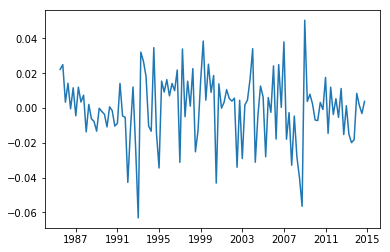

In [49]:
plt.plot(ecm_res.resid)
plt.show()

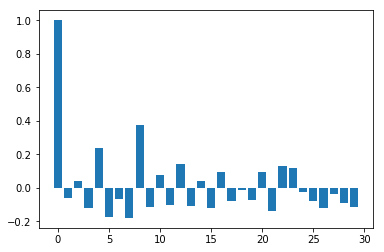

In [50]:
plt.bar(np.arange(30), acf(ecm_res.resid)[:30])
plt.show()

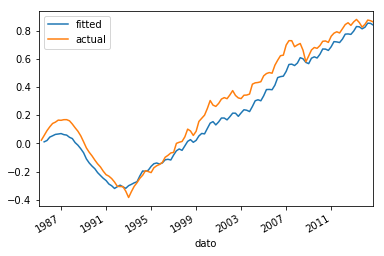

In [51]:
plt.plot(lim_data.index[2:], ecm_mod.predict(ecm_res.params).cumsum(), label = 'fitted')
lim_data['log_PBOL_KPI'].diff().cumsum().plot(label = 'actual')
plt.legend()
plt.show()

In [52]:
adfuller(ecm_res.resid)

(-3.3841878145343567,
 0.011509864470541673,
 7,
 110,
 {'1%': -3.4912451337340342,
  '10%': -2.5809876033057852,
  '5%': -2.8881954545454547},
 -523.9165836255147)

In [53]:
#one-step predict
pred = ecm_mod.predict(ecm_res.params, mod_data[['Dlog_PBOL_KPI_1','Dlog_BG_KPI_1','Dlog_K83_1', 'Dlog_RD_KPI_1', 'DRRT_1', 'Anundsen error_1','const','DKV1_step','DKV2_step','DKV3_step']][2:])
pred = pd.Series(pred, index = mod_data.index[2:])

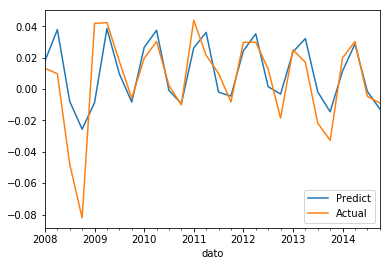

In [54]:
#one-step predict
pred['2008':].plot(label = 'Predict')
mod_data['Dlog_PBOL_KPI']['2008':].plot(label = 'Actual')
plt.legend()
plt.show()

In [55]:
#forecast er en predict-funksjon som bruker sine egne predikerte verdier til neste prediksjon av den avhengige variabel
def forecast(params, exog, start, var):
    new = exog.copy()
    for i in range(start, len(exog)):
        new[var].iloc[i] = np.dot(params, new.iloc[i-1])
    return new[var]

In [56]:
forecast = forecast(ecm_res.params, mod_data[['Dlog_PBOL_KPI_1','Dlog_BG_KPI_1','Dlog_K83_1', 'Dlog_RD_KPI_1', 'DRRT_1', 'Anundsen error_1','const','DKV1_step','DKV2_step','DKV3_step']][2:], 92, 'Dlog_PBOL_KPI_1')

C:\Users\i235hat\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


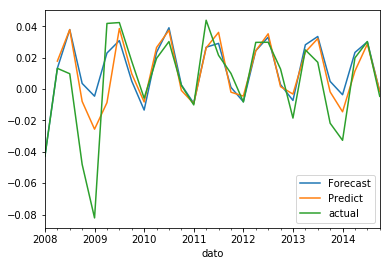

In [57]:
forecast['2008':].plot(label = 'Forecast')
pred['2008':].shift().plot(label = 'Predict')
mod_data['Dlog_PBOL_KPI_1']['2008':].plot(label = 'actual')
plt.legend()
plt.show()

In [61]:
begrep

{'BF300': 'Private bruttofordringer',
 'BG300': 'Privat gjeld',
 'HUSBOL': 'Husholdningsektorens boligkapital',
 'HUSFORMUE': 'Husholdningens formue',
 'JKBOL': 'Investering boligkapital',
 'K83': 'Boligkapitalbeholdning',
 'KBOL': 'Boligkapital',
 'KPI': 'KPI',
 'NB': 'Antall personer i kilo',
 'NFI300': 'Privat nettofinansinvestering',
 'PBOL': 'Boligprisindeks',
 'PC': 'Privat konsum',
 'PJ10': 'Pris på investering i boligmasse',
 'RAM300': 'Privat aksjeutbytte',
 'RD300': 'Privat netto disponibel inntekt',
 'RENPF300BO': 'Rente på lån med pant i bolig',
 'SPARERAT': 'Husholdningens sparerate',
 'TRTMNW': 'Gjennomsnitt marginal skatterate',
 'XSBOLU': 'Igangsetting av bolig i kkvm'}

# Sammenheng rd = const + alpha*ww + beta*nb

In [152]:
data['Adj_RD'] = data['RD300'] - data['RAM300']
res = smf.ols('np.log(Adj_RD) - asd ~ 1 + np.log(WW) + np.log(NB)', data=data, missing = 'drop').fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         np.log(Adj_RD)   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.403e+04
Date:                Wed, 28 Jun 2017   Prob (F-statistic):           3.92e-68
Time:                        16:13:14   Log-Likelihood:                 104.59
No. Observations:                  45   AIC:                            -203.2
Df Residuals:                      42   BIC:                            -197.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9103      1.071      1.784      0.082      -0.250       4.071
np.log(WW)     1.1546      0.013     91.338      0.000       1.129       1.180
np.log(NB)     0.4155      0.135      3.078      0.004       0.143       0.688
==============================================================================
Omnibus:                        0.025   Durbin-Watson:                   0.741
Prob(Omnibus):                  0.988   Jarque-Bera (JB):                0.059
Skew:                          -0.018   Prob(JB):                        0.971
Kurtosis:                       2.826   Cond. No.                     2.92e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.92e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [149]:
adfuller(res.resid)

(-2.9671556994692092,
 0.038077579879856036,
 4,
 40,
 {'1%': -3.6055648906249997,
  '10%': -2.6069856250000001,
  '5%': -2.9370693750000001},
 -174.42207859347189)

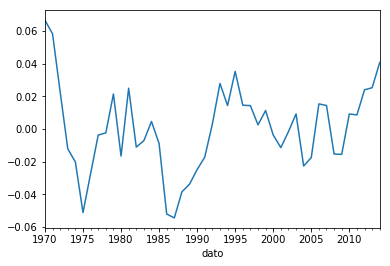

In [150]:
res.resid.plot()
plt.show()

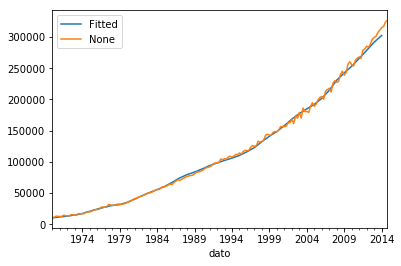

In [151]:
np.exp(res.fittedvalues).plot(label = 'Fitted')
(data['RD300']-data['RAM300']).plot()
plt.legend()
plt.show()